# import 

In [1]:
import torch
import torch.nn.functional as F
import torch.utils.data as Data
from torch.autograd import Variable
import pandas as pd
import numpy as np
import time
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import mutual_info_classif
import datetime
import pickle
import scipy.sparse as ss
import logging
LOG_FORMAT = "%(asctime)s - %(levelname)s - %(message)s"
logging.basicConfig(level=logging.INFO, format=LOG_FORMAT)
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['NUMEXPR_MAX_THREADS'] = '32'
# import seaborn as sns

import IPython.display as ipd
import copy
import random
from pandarallel import pandarallel
# Initialization
pandarallel.initialize(progress_bar=True)
# df.parallel_apply(func)
import time
from gensim.models.word2vec import Word2Vec 
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold,KFold

from transformers import *
import torch.nn as nn
import math
from tqdm import tqdm_notebook as tqdm
from transformers.modeling_bert import BertConfig, BertEncoder, BertAttention,\
BertSelfAttention,BertLayer,BertPooler,BertLayerNorm

from gensim.models.word2vec import Word2Vec 
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold,KFold
from scipy.special import softmax

from category_encoders import *

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


2021-03-03 17:44:20,706 - INFO - PyTorch version 1.1.0 available.
/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/huangweilin/anaconda3/envs/hyr/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([

# Read

In [2]:
logging.info('start read')
df_master_records = pickle.load(open('../data_sortout/df_master_records.pickle', 'rb'))
se_id_install_list = pickle.load(open('../data_sortout/se_id_install_list.pickle', 'rb'))
df_install_behave = pickle.load(open('../data_sortout/df_install_behave_no_date.pickle', 'rb'))
df_behave_time = pickle.load(open('../data_sortout/df_time_cut.pickle', 'rb'))
# df_userlog = pickle.load(open('../data_sortout/df_userlog_sequence_less.pickle', 'rb'))
se_userlog_cross = pickle.load(open('../data_sortout/se_userlog_cross_id.pickle', 'rb'))
df_userlog_time_seq = pickle.load(open('../data_sortout/df_userlog_time_seq.pickle', 'rb'))

# df_app_list_te_sequence = pickle.load(open('../data_sortout/df_app_list_target_encode_sequence.pickle', 'rb'))
# df_app_behave_te_sequence = pickle.load(open('../data_sortout/df_app_behave_target_encode_sequence.pickle', 'rb'))

df_app_list_te_qcut = pickle.load(open('../data_sortout/df_app_list_target_qcut.pickle', 'rb'))
df_app_behave_te_qcut = pickle.load(open('../data_sortout/df_app_behave_target_qcut.pickle', 'rb'))


logging.info('finish read')

2021-03-03 17:44:22,204 - INFO - start read
2021-03-03 17:45:30,062 - INFO - finish read


# 数据划分

In [3]:
split_date = datetime.datetime(2019, 8, 31)
end_date = datetime.datetime(2019, 9, 30)

df_master_records = df_master_records.dropna(axis=0, how='any')
df_train_master = df_master_records.query('loan_date <= @split_date')
df_test_master = df_master_records.query('loan_date > @split_date & loan_date <= @end_date')
all_train_id = list(df_train_master.index)
all_test_id = list(df_test_master.index)
logging.info('all_train_id len :%d, all_test_id: %d' % (len(all_train_id), len(all_test_id)))
df_target = df_master_records[['target_1m30+', 'target_2m30+', 'target_3m30+', 'target_4m30+']]

2021-03-03 17:45:30,363 - INFO - all_train_id len :326082, all_test_id: 75896


In [4]:
max_app_list_id = max(se_id_install_list.apply(max))
max_app_behave_id = max(df_install_behave['pkg_id'].apply(max))
max_uselog_id = max(se_userlog_cross.apply(max))
start_app_list_id = max_app_list_id + 1
start_app_behave_id = max_app_behave_id + 1 
start_uselog_id = max_uselog_id + 1

# Feature

## user info

In [5]:
def get_master_user_discrete(df_master_records):
    
    df_master_records['qcut_amount_bin'] = pd.qcut(df_master_records['amount_bin'], 5)
    df_master_records['new_client'] = df_master_records['loan_sequence'] == 1
    df_master_records['qcut_age'] = pd.qcut(df_master_records['age'], 5, duplicates='drop')
    
    df_master_records['qcut_min_income'] = pd.qcut(df_master_records['min_income'], 6, duplicates='drop')
    df_master_records['qcut_max_income'] = pd.qcut(df_master_records['max_income'].apply(int), 6, duplicates='drop')

#     df_master_records['qcut_loan_sequence'] = pd.qcut(df_master_records['loan_sequence'], 6, duplicates='drop')
#     pne_hot_cols = ['months', 'gender', 'educationid', 'marriagestatusid', 'income', 
#                     'qcut_amount_bin', 'new_client', 'qcut_loan_sequence', 'qcut_age', 'qcut_min_income', 'qcut_max_income']
    pne_hot_cols = ['months', 'gender', 'educationid', 'marriagestatusid', 'income', 
                'qcut_amount_bin', 'qcut_age', 'qcut_min_income', 'qcut_max_income']

    return  pd.get_dummies(df_master_records[pne_hot_cols], columns = pne_hot_cols)
df_user_one_hot = get_master_user_discrete(df_master_records)

In [6]:
df_user_one_hot.shape

(401978, 102)

## word2vec

In [7]:
wv_model_app_list = pickle.load(open('../data_sortout/wv_model_app_list.pickle', 'rb'))
wv_model_app_behave = pickle.load(open('../data_sortout/wv_model_app_behave.pickle', 'rb'))
wv_model_userlog = pickle.load(open('../data_sortout/wv_model_userlog_cross.pickle', 'rb'))

# train

## 调参

In [8]:
from collections import namedtuple

ARG = namedtuple('ARG', [
    'batch_size',
    'epoch',
    'lr',
    'weight_decay',
    'debug',
    'n_embedding',
    'app_install_list_max_length',
    'app_behave_max_length',
    'userlog_max_length',
    'n_eval',
    'dropout_rate',
    'n_worker',
    'use_cuda',
    'n_gpu',
    'device',
    'card_list'
])
 
args = ARG(
    batch_size = 256,
    epoch = 10,
    lr = 0.001,
    weight_decay = 0.0,
    dropout_rate = 0.,
    debug = False,
    n_embedding = 100,
    app_install_list_max_length = 256,
    app_behave_max_length = 256,
    userlog_max_length = 256,
    n_eval = len(all_test_id)+1,
    n_worker = 0,
    use_cuda = True,
    n_gpu = 1,
    card_list = [0, 1],
    device=torch.device("cuda:1"),
#     device=torch.device("cpu")

)

## dataset

In [9]:
install_behave_set = set(df_install_behave.index) & (set(all_train_id) | set(all_test_id))
install_list_set = set(se_id_install_list.index) & (set(all_train_id) | set(all_test_id))
user_info_set = set(df_user_one_hot.index) & (set(all_train_id) | set(all_test_id))
user_log_set = set(se_userlog_cross.index) & (set(all_train_id) | set(all_test_id))

In [10]:
class AppDataset(Data.Dataset):
    def __init__(self, master_ids):
        self.master_ids = list(master_ids)
        
    def __len__(self):
        return len(self.master_ids)
    
    def __getitem__(self,idx):
        return self.master_ids[idx]

x_dict = {
    
    'user_info' : np.zeros((args.batch_size, df_user_one_hot.shape[1])),

    'app_list' : np.zeros((args.batch_size, args.app_install_list_max_length + 1)).astype('int'),
    'app_list_te_qcut' : np.zeros((args.batch_size, args.app_install_list_max_length + 1, 4)).astype('int'),
    'app_list_len' :  np.zeros((args.batch_size,)).astype('int'),
    
    'app_behave' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_time_cut' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_time_qcut' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    
    'app_behave_action' : np.zeros((args.batch_size, args.app_behave_max_length + 1)).astype('int'),
    'app_behave_te_qcut' : np.zeros((args.batch_size, args.app_behave_max_length + 1, 4)).astype('int'),

    'app_behave_len' :  np.zeros((args.batch_size,)).astype('int'),
    
    'userlog' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_len' :  np.zeros((args.batch_size,)).astype('int'),
    'userlog_day_qcut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_day_cut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_second_qcut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    'userlog_second_cut' : np.zeros((args.batch_size, args.userlog_max_length + 1)).astype('int'),
    
    'view_mask' : np.zeros((args.batch_size, 4)).astype('int'),
}

def set_first_token():
    x_dict['app_list'][:, 0] = start_app_list_id
    x_dict['app_behave'][:, 0] = start_app_behave_id
    x_dict['userlog'][:, 0] = start_uselog_id

    x_dict['app_list'][:, 0] = 0
    x_dict['app_behave'][:, 0] = 0
    x_dict['userlog'][:, 0] = 0

    x_dict['userlog_day_qcut'][:, 0] = 8
    x_dict['userlog_day_cut'][:, 0] = 8
    x_dict['userlog_second_qcut'][:, 0] = 32
    x_dict['userlog_second_cut'][:, 0] = 32

set_first_token()

def collate_fn(master_ids):
    master_ids = np.array(master_ids)

#     sub_master_id = se_id_install_list.loc[master_ids]
#     df_sub_behave = df_install_behave.loc[master_ids]
#     df_sub_time = df_behave_time.loc[master_ids]
    for i, master_id in enumerate(master_ids):
        if master_id in user_info_set:
            x_dict['user_info'][i] = df_user_one_hot.loc[master_id].values
            x_dict['view_mask'][i][0] = 1
        else:
            x_dict['user_info'][i] = 0
            x_dict['view_mask'][i][0] = 0

        if master_id in install_list_set:
            app_list = se_id_install_list.at[master_id][:args.app_install_list_max_length]
            x_dict['app_list_len'][i] = len(app_list) + 1
            x_dict['app_list'][i][1 : x_dict['app_list_len'][i]] = app_list
            x_dict['app_list'][i][x_dict['app_list_len'][i] :] = 0
            
#             target_encode_data = np.array(list(df_app_list_te_qcut.loc[master_id].values))[:, :args.app_install_list_max_length].T
#             x_dict['app_list_te_qcut'][i][1 : x_dict['app_list_len'][i]] = target_encode_data
            
            x_dict['view_mask'][i][1] = 1
        else:
            x_dict['app_list_len'][i] = 1
            x_dict['app_list'][i][1:] = 0
            x_dict['app_list_te_qcut'][i] = 0
            x_dict['view_mask'][i][1] = 0

        if master_id in install_behave_set:
            app_behave = df_install_behave['pkg_id'].at[master_id][-args.app_behave_max_length:]
            len_app = len(app_behave) + 1
            x_dict['app_behave_len'][i] = len_app
            x_dict['app_behave'][i][1: len_app] = app_behave
            x_dict['app_behave'][i][len_app :] = 0
            
#             target_encode_data = np.array(list(df_app_behave_te_qcut.loc[master_id].values))[:, -args.app_behave_max_length:].T
#             x_dict['app_behave_te_qcut'][i][1 : len_app] = target_encode_data
            
            x_dict['app_behave_time_cut'][i][1:len_app] = df_behave_time['cut_id'].at[master_id][-args.app_behave_max_length:]
            x_dict['app_behave_time_qcut'][i][1:len_app] = df_behave_time['qcut_id'].at[master_id][-args.app_behave_max_length:]
            x_dict['app_behave_action'][i][1:len_app] = df_install_behave['action'].at[master_id][-args.app_behave_max_length:]
            x_dict['view_mask'][i][2] = 1
        else:
            x_dict['app_behave_len'][i] = 1
            x_dict['app_behave'][i][1:] = 0
            x_dict['app_behave_te_qcut'][i] = 0

            x_dict['app_behave_time_cut'][i][1:] = 0
            x_dict['app_behave_time_qcut'][i][1:] = 0
            x_dict['app_behave_action'][i][1:] = 0
            x_dict['view_mask'][i][2] = 0
        
        
        if master_id in user_log_set:
            userlog_list = se_userlog_cross.at[master_id][:args.userlog_max_length]
            len_userlog = len(userlog_list) + 1
            x_dict['userlog_len'][i] = len_userlog
            x_dict['userlog'][i][1 : len_userlog] = userlog_list
            x_dict['userlog'][i][len_userlog :] = 0
            x_dict['userlog_day_qcut'][i][1 : len_userlog] = df_userlog_time_seq['qcut_day_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_day_qcut'][i][len_userlog :] = 0
            x_dict['userlog_day_cut'][i][1 : len_userlog] = df_userlog_time_seq['cut_day_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_day_cut'][i][len_userlog :] = 0
            x_dict['userlog_second_qcut'][i][1 : len_userlog] = df_userlog_time_seq['qcut_second_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_second_qcut'][i][len_userlog :] = 0
            x_dict['userlog_second_cut'][i][1 : len_userlog] = df_userlog_time_seq['cut_second_id'].at[master_id][:args.userlog_max_length]
            x_dict['userlog_second_cut'][i][len_userlog :] = 0

            x_dict['view_mask'][i][3] = 1
        else:
            x_dict['userlog_len'][i] = 1
            x_dict['userlog'][i] = 0
            x_dict['userlog_day_qcut'][i] = 0
            x_dict['userlog_day_cut'][i] = 0
            x_dict['userlog_second_qcut'][i] = 0
            x_dict['userlog_second_cut'][i] = 0

            x_dict['view_mask'][i][3] = 0
    
    
    len_id = master_ids.shape[0]
    x_dict['app_list'][len_id:] = 0
    x_dict['app_behave'][len_id:] = 0
    return {
        
        'user_info' : torch.tensor(x_dict['user_info'][:len_id]).float(),
        
        'app_list' : torch.tensor(x_dict['app_list'][:len_id]).long(),
        'app_list_te_qcut' : torch.tensor(x_dict['app_list_te_qcut'][:len_id]).long(),
        'app_list_len' : torch.tensor(x_dict['app_list_len'][:len_id]).long(),
        
        'app_behave' : torch.tensor(x_dict['app_behave'][:len_id]).long(),
        'app_behave_te_qcut' : torch.tensor(x_dict['app_behave_te_qcut'][:len_id]).long(),
        'app_behave_len' : torch.tensor(x_dict['app_behave_len'][:len_id]).long(),
        
        'app_behave_time_cut' : torch.tensor(x_dict['app_behave_time_cut'][:len_id]).long(),
        'app_behave_time_qcut' : torch.tensor(x_dict['app_behave_time_qcut'][:len_id]).long(),
        'app_behave_action' : torch.tensor(x_dict['app_behave_action'][:len_id]).long(),
        'userlog' : torch.tensor(x_dict['userlog'][:len_id]).long(),
        'userlog_len' : torch.tensor(x_dict['userlog_len'][:len_id]).long(),
        'userlog_day_qcut' : torch.tensor(x_dict['userlog_day_qcut'][:len_id]).long(),
        'userlog_day_cut' : torch.tensor(x_dict['userlog_day_cut'][:len_id]).long(),
        'userlog_second_qcut' : torch.tensor(x_dict['userlog_second_qcut'][:len_id]).long(),
        'userlog_second_cut' : torch.tensor(x_dict['userlog_second_cut'][:len_id]).long(),

        'view_mask' : torch.tensor(x_dict['view_mask'][:len_id]).long(),
        'labels1' : torch.tensor(df_target.loc[master_ids]['target_1m30+'].values).long(),
        'labels2' : torch.tensor(df_target.loc[master_ids]['target_2m30+'].values).long(),
        'labels3' : torch.tensor(df_target.loc[master_ids]['target_3m30+'].values).long(),
        'labels4' : torch.tensor(df_target.loc[master_ids]['target_4m30+'].values).long(),
    }

## model

### embed weight

In [11]:
def get_app_list_wv_weight():
    weight = np.zeros((start_app_list_id+1, 100))
    for i in tqdm(range(1, start_app_list_id+1)):
        weight[i] = wv_model_app_list.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

def get_app_behave_wv_weight():
    weight = np.zeros((start_app_behave_id+1, 100))
    for i in tqdm(range(1, start_app_behave_id+1)):
        weight[i] = wv_model_app_behave.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

def get_userlog_wv_weight():
    weight = np.zeros((start_uselog_id+1, 100))
    for i in tqdm(range(1, start_uselog_id+1)):
        weight[i] = wv_model_userlog.wv[str(i)]
    weight_tensor = torch.tensor(weight).float()
    return weight_tensor

app_list_weight = get_app_list_wv_weight()
app_behave_weight = get_app_behave_wv_weight()
userlog_weight = get_userlog_wv_weight()

### sub model

In [12]:
def masked_softmax(X, valid_len):
    if valid_len is None:
        return F.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])
        mask = (torch.arange(0,X.shape[-1]).repeat(X.shape[0],1).to(args.device) < valid_len).repeat(1, X.shape[1]).view(shape)
        
        X = X.masked_fill_(~mask, -float('inf'))
        return F.softmax(X,dim=-1).view(shape)

def make_mask(X, valid_len):
    if valid_len is None:
        return F.softmax(X,dim=-1)
    else:
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])

        mask=(torch.arange(0,X.shape[1]).repeat(X.shape[0],1).to(X.device)<valid_len).byte()
        return mask.unsqueeze(2) 

class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # `query`: (`batch_size`, #queries, `d`)
    # `key`: (`batch_size`, #kv_pairs, `d`)
    # `value`: (`batch_size`, #kv_pairs, `dim_v`)
    # `valid_len`: either (`batch_size`, ) or (`batch_size`, xx)
    def forward(self, query, key, value, valid_len=None):
        d = query.shape[-1]
        # Set transpose_b=True to swap the last two dimensions of key
        scores = torch.bmm(query, key.transpose(1,2)) / math.sqrt(d)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return torch.bmm(attention_weights, value)
    
class MLPAttention(nn.Module):
    def __init__(self, key_size, query_size, units, dropout=0., **kwargs):
        super(MLPAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, units, bias=False)
        self.W_q = nn.Linear(query_size, units, bias=False)
        self.v = nn.Linear(units, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, valid_len):
        query, key = self.W_k(query), self.W_q(key)
        # Expand query to (`batch_size`, #queries, 1, units), and key to
        # (`batch_size`, 1, #kv_pairs, units). Then plus them with broadcast
        features = query.unsqueeze(2) + key.unsqueeze(1)
        scores = self.v(features).squeeze(-1)
        attention_weights = self.dropout(masked_softmax(scores, valid_len))
        return torch.bmm(attention_weights, value)

class LayerNorm(nn.Module):
    def __init__(self,features,eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma=nn.Parameter(torch.ones(features))
        self.beta=nn.Parameter(torch.zeros(features))
        self.eps=eps
    def forward(self,X):
        mean=X.mean(-1,keepdim=True)
        std=X.std(-1,keepdim=True)
        return self.gamma*(X-mean)/(std+self.eps)+self.beta
    
class MLPAttentionPool(nn.Module):
    def __init__(self,key_size,units):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(key_size,units,bias=False),
                                  nn.Tanh(),
                                  nn.Linear(units,1,bias=False))
        
    def masked_softmax_1d(self, X, valid_len):
        if valid_len is None:
            return F.softmax(X,dim=-1), _
        else:
            shape=X.shape
            if valid_len.dim()==1:
                valid_len=valid_len.view(-1,1).repeat(1,shape[1])

            mask=(torch.arange(0,X.shape[-1]).repeat(X.shape[0],1).to(X.device)<valid_len).byte()
            X = X.masked_fill_(~mask, -float('inf'))
            return F.softmax(X,dim=-1).view(shape), mask

    def forward(self, key, valid_len):
        scores = self.proj(key).squeeze(-1)
        attention_weights, mask = self.masked_softmax_1d(scores,valid_len)
        seq_out = attention_weights.unsqueeze(-1) * key
        return seq_out.sum(1)

class GeLU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1. + torch.tanh(x * 0.7978845608 * (1. + 0.044715 * x * x)))

class Dense(nn.Module):
    def __init__(self, in_feature, out_feature):
        super().__init__()
        hidden = 128
        self.dense = nn.Sequential(
            nn.Linear(in_feature, hidden),
            GeLU(),
            nn.Dropout(args.dropout_rate),
            nn.Linear(hidden, out_feature)
        )
        self.dense.apply(self._init_weights)
        
    def _init_weights(self, module):
        """ Initialize the weights """
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        return self.dense(x)

class UserNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
        n_dim = df_user_one_hot.shape[1]
        self.dense_hidden = Dense(n_dim, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        x = input_dict['user_info'].to(args.device)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        hidden = self.dense_hidden(x)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class AppListNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = 64
        self.input_size = 100
        self.embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.layer_norm = LayerNorm(self.input_size)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(self.input_size, self.input_size, 256)

        self.attention_layer = MLPAttentionPool(self.input_size, config.hidden)
        self.dense_hidden = Dense(self.input_size, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)

        app_list = self.embeddings(app_list_ids)
        app_list = self.layer_norm(app_list)

        x = self.attention_layer(app_list, app_list_len)
        
        hidden = self.dense_hidden(x)        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class AppBehaveNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden
        self.embeddings = nn.Embedding.from_pretrained(app_behave_weight)        
        for i in self.embeddings.parameters():
            i.requires_grad=False
        
        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
#         self.action_embeddings = nn.Embedding(2, 4)

        
        self.layer_norm = LayerNorm(100)
        self.rnn = nn.GRU(16 + 16 + 100,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(config.hidden, config.hidden, config.hidden)
        self.attention_layer = MLPAttentionPool(config.hidden, config.hidden)

        self.dense_hidden = Dense(config.hidden, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)

    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
   
    def forward(self, input_dict):
        
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
#         app_behave_action = input_dict['app_behave_action'].to(args.device)
        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        app_behave = self.embeddings(app_behave_ids)
#         app_behave = self.layer_norm(app_behave)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             action_embed,
        ], dim = -1)
        
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)
        
        x = self.attention_layer(rnn_out, app_behave_len)
#         mask = make_mask(x, app_behave_len)
#         x = x.masked_fill_(~mask, 0).sum(1)

        
        hidden = self.dense_hidden(x)
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

class UserlogNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config.hidden
        self.embeddings = nn.Embedding.from_pretrained(userlog_weight)        
#         for i in self.embeddings.parameters():
#             i.requires_grad=False
        self.embeddings_day_qcut = nn.Embedding(9, 8)
        self.embeddings_day_cut = nn.Embedding(9, 8)
        self.embeddings_second_qcut = nn.Embedding(33, 16)
        self.embeddings_second_cut = nn.Embedding(33, 16)

        
        self.layer_norm = LayerNorm(100)
        self.rnn = nn.GRU(100 + 8 + 16 + 8 + 16,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
#         self.attention_layer = DotProductAttention(0.)
#         self.attention_layer = MLPAttention(config.hidden, config.hidden, config.hidden)
        self.attention_layer = MLPAttentionPool(config.hidden, config.hidden)

        self.dense_hidden = Dense(config.hidden, config.hidden)

        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)

    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
   
    def forward(self, input_dict):
        
        userlog_action_id = input_dict['userlog'].to(args.device)
        userlog_len = input_dict['userlog_len'].to(args.device)
        userlog_day_qcut_id = input_dict['userlog_day_qcut'].to(args.device)
        userlog_day_cut_id = input_dict['userlog_day_cut'].to(args.device)
        userlog_second_qcut_id = input_dict['userlog_second_qcut'].to(args.device)
        userlog_second_cut_id = input_dict['userlog_second_cut'].to(args.device)

        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        userlog_action = self.embeddings(userlog_action_id)
#         app_behave = self.layer_norm(app_behave)
        userlog_day_qcut = self.embeddings_day_qcut(userlog_day_qcut_id)
        userlog_day_cut = self.embeddings_day_cut(userlog_day_cut_id)
        userlog_second_qcut = self.embeddings_second_qcut(userlog_second_qcut_id)
        userlog_second_cut = self.embeddings_second_cut(userlog_second_cut_id)
        hidden = torch.cat([
            userlog_action,
            userlog_day_qcut,
            userlog_day_cut,
            userlog_second_qcut,
            userlog_second_cut], dim = -1)
        
    
        rnn_out = self.rnn_forward(hidden, userlog_len)
        
        x = self.attention_layer(rnn_out, userlog_len)
#         mask = make_mask(x, app_behave_len)
#         x = x.masked_fill_(~mask, 0).sum(1)

        
        hidden = self.dense_hidden(x)
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
         
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

### interactive model

In [13]:
class Alignment(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.temperature = nn.Parameter(torch.tensor(1 / math.sqrt(config.hidden)))
        self.summary = {}

    def _attention(self, a, b):
        return torch.matmul(a, b.transpose(1, 2)) * self.temperature
    
    def forward(self, a, b, mask_a, mask_b):
        attn = self._attention(a, b)
        mask = torch.matmul(mask_a.float(), mask_b.transpose(1, 2).float()).byte()
        attn.masked_fill_(~mask, -1e7)
        attn_a = F.softmax(attn, dim=1)
        attn_b = F.softmax(attn, dim=2)
        feature_b = torch.matmul(attn_a.transpose(1, 2), a)
        feature_a = torch.matmul(attn_b, b)
        return feature_a, feature_b

class MappedAlignment(Alignment):
    def __init__(self, config):
        super().__init__(config)
        self.projection = nn.Sequential(
            nn.Dropout(args.dropout_rate),
            Dense(config.hidden, config.hidden),
        )

    def _attention(self, a, b):
        a = self.projection(a)
        b = self.projection(b)
        return super()._attention(a, b)

class FullFusion(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dropout = args.dropout_rate
        self.fusion1 = Dense(config.hidden * 2, config.hidden)
        self.fusion2 = Dense(config.hidden * 2, config.hidden)
        self.fusion3 = Dense(config.hidden * 2, config.hidden)
        self.fusion = Dense(config.hidden * 3, config.hidden)

    def forward(self, x, align):
        x1 = self.fusion1(torch.cat([x, align], dim=-1))
        x2 = self.fusion2(torch.cat([x, x - align], dim=-1))
        x3 = self.fusion3(torch.cat([x, x * align], dim=-1))
        x = torch.cat([x1, x2, x3], dim=-1)
        x = F.dropout(x, self.dropout, self.training)
        return self.fusion(x)

class AppConcat(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.applist_embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.appbehave_embeddings = nn.Embedding.from_pretrained(app_behave_weight)
        for i in self.applist_embeddings.parameters():
            i.requires_grad=False
        for i in self.appbehave_embeddings.parameters():
            i.requires_grad=False
        

        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
        self.action_embeddings = nn.Embedding(2, 4)
        
        self.app_list_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])
        self.app_behave_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])

        self.app_list_encoder = Dense(100, config.hidden)
#         self.app_list_encoder = Dense(16 * 4, config.hidden)
        self.attention_layer1 = MLPAttentionPool(config.hidden, config.hidden)
        self.attention_layer2 = MLPAttentionPool(config.hidden, config.hidden)


        self.rnn = nn.GRU(16 + 16 + 100,
#         self.rnn = nn.GRU(16 * 4,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)        
        
        
        self.dense = Dense(config.hidden * 2, config.hidden)
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
    
    def maxpool(self, x, mask):
        return x.masked_fill_(~mask, -float('inf')).max(dim=1)[0]

    def app_behave_encode(self, input_dict):
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
        app_behave_action = input_dict['app_behave_action'].to(args.device)
   
#         app_behave_target_encode = input_dict['app_behave_target_encode'].to(args.device)
        
        app_behave_target_qcut = input_dict['app_behave_te_qcut'].to(args.device)

#         app_behave_target_qcut_embed1 = self.app_behave_qcut_embed_list[0](app_behave_target_qcut[:, :, 0])
#         app_behave_target_qcut_embed2 = self.app_behave_qcut_embed_list[1](app_behave_target_qcut[:, :, 1])
#         app_behave_target_qcut_embed3 = self.app_behave_qcut_embed_list[2](app_behave_target_qcut[:, :, 2])
#         app_behave_target_qcut_embed4 = self.app_behave_qcut_embed_list[3](app_behave_target_qcut[:, :, 3])

        app_behave = self.appbehave_embeddings(app_behave_ids)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             app_behave_target_qcut_embed1,
#             app_behave_target_qcut_embed2,
#             app_behave_target_qcut_embed3,
#             app_behave_target_qcut_embed4,
#             app_behave_target_encode,
#             action_embed,
        ], dim = -1)
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)

        return rnn_out, app_behave_len
    
    def app_list_encode(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        app_list_embed = self.applist_embeddings(app_list_ids)
        
        app_list_target_qcut = input_dict['app_list_te_qcut'].to(args.device)
#         app_list_target_encode = input_dict['app_list_target_encode'].to(args.device)

        app_list_target_qcut_embed1 = self.app_list_qcut_embed_list[0](app_list_target_qcut[:, :, 0])
        app_list_target_qcut_embed2 = self.app_list_qcut_embed_list[1](app_list_target_qcut[:, :, 1])
        app_list_target_qcut_embed3 = self.app_list_qcut_embed_list[2](app_list_target_qcut[:, :, 2])
        app_list_target_qcut_embed4 = self.app_list_qcut_embed_list[3](app_list_target_qcut[:, :, 3])

        seq_data = torch.cat([
            app_list_embed, 
#             app_list_target_encode,
#             app_list_target_qcut_embed1,
#             app_list_target_qcut_embed2,
#             app_list_target_qcut_embed3,
#             app_list_target_qcut_embed4,

        ], dim = -1)
        
        return self.app_list_encoder(seq_data), app_list_len 
    

    def forward(self, input_dict):
        a, a_len = self.app_behave_encode(input_dict)
        b, b_len = self.app_list_encode(input_dict)
#         mask_a = self.make_mask(a, a_len)
#         mask_b = self.make_mask(b, b_len)
                
        a = self.attention_layer1(a, a_len)
        b = self.attention_layer2(b, b_len)
        
        hidden = self.dense(torch.cat([a, b], dim=-1)) 

        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden
    
class AppInteractiveNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.applist_embeddings = nn.Embedding.from_pretrained(app_list_weight)
        self.appbehave_embeddings = nn.Embedding.from_pretrained(app_behave_weight)
        for i in self.applist_embeddings.parameters():
            i.requires_grad=False
        for i in self.appbehave_embeddings.parameters():
            i.requires_grad=False
        

        self.qcut_time_embeddings = nn.Embedding(64, 16)
        self.cut_time_embeddings = nn.Embedding(64, 16)
        self.action_embeddings = nn.Embedding(2, 4)
        
        self.app_list_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])
        self.app_behave_qcut_embed_list = nn.ModuleList([nn.Embedding(17, 16) for _ in range(4)])

        self.app_list_encoder = Dense(100, config.hidden)
#         self.app_list_encoder = Dense(16 * 4, config.hidden)


        self.rnn = nn.GRU(16 + 16 + 100,
#         self.rnn = nn.GRU(16 * 4,
                          hidden_size = config.hidden,
                          num_layers = 1,
                          dropout = 0,
                          bidirectional = False, 
                          batch_first=True)
        
        self.alignment_layer = MappedAlignment(config)
        self.fusion_layer = FullFusion(config)
        
        
        
        self.dense = Dense(config.hidden * 4, config.hidden)
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def rnn_forward(self, x, x_lens):
        X = torch.nn.utils.rnn.pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        hidden, _= self.rnn(X)
        hidden, _ = torch.nn.utils.rnn.pad_packed_sequence(hidden,total_length=x.shape[1],batch_first=True)
        return hidden
    
    def maxpool(self, x, mask):
        return x.masked_fill_(~mask, -float('inf')).max(dim=1)[0]

    def app_behave_encode(self, input_dict):
        app_behave_ids = input_dict['app_behave'].to(args.device)
        app_behave_len = input_dict['app_behave_len'].to(args.device)
        app_behave_time_cut = input_dict['app_behave_time_cut'].to(args.device)
        app_behave_time_qcut = input_dict['app_behave_time_qcut'].to(args.device)
        app_behave_action = input_dict['app_behave_action'].to(args.device)
   
#         app_behave_target_encode = input_dict['app_behave_target_encode'].to(args.device)
        
#         app_behave_target_qcut = input_dict['app_behave_te_qcut'].to(args.device)

#         app_behave_target_qcut_embed1 = self.app_behave_qcut_embed_list[0](app_behave_target_qcut[:, :, 0])
#         app_behave_target_qcut_embed2 = self.app_behave_qcut_embed_list[1](app_behave_target_qcut[:, :, 1])
#         app_behave_target_qcut_embed3 = self.app_behave_qcut_embed_list[2](app_behave_target_qcut[:, :, 2])
#         app_behave_target_qcut_embed4 = self.app_behave_qcut_embed_list[3](app_behave_target_qcut[:, :, 3])

        app_behave = self.appbehave_embeddings(app_behave_ids)
        cut_time_embed = self.cut_time_embeddings(app_behave_time_cut)
        qcut_time_embed = self.cut_time_embeddings(app_behave_time_qcut)
#         action_embed = self.action_embeddings(app_behave_action)
        
        seq_data = torch.cat([
            app_behave, 
            cut_time_embed,
            qcut_time_embed,
#             app_behave_target_qcut_embed1,
#             app_behave_target_qcut_embed2,
#             app_behave_target_qcut_embed3,
#             app_behave_target_qcut_embed4,
#             app_behave_target_encode,
#             action_embed,
        ], dim = -1)
        
        rnn_out = self.rnn_forward(seq_data, app_behave_len)

        return rnn_out, app_behave_len
    
    def app_list_encode(self, input_dict):
        app_list_ids = input_dict['app_list'].to(args.device)
        app_list_len = input_dict['app_list_len'].to(args.device)
        app_list_embed = self.applist_embeddings(app_list_ids)
        
        app_list_target_qcut = input_dict['app_list_te_qcut'].to(args.device)
#         app_list_target_encode = input_dict['app_list_target_encode'].to(args.device)

        app_list_target_qcut_embed1 = self.app_list_qcut_embed_list[0](app_list_target_qcut[:, :, 0])
        app_list_target_qcut_embed2 = self.app_list_qcut_embed_list[1](app_list_target_qcut[:, :, 1])
        app_list_target_qcut_embed3 = self.app_list_qcut_embed_list[2](app_list_target_qcut[:, :, 2])
        app_list_target_qcut_embed4 = self.app_list_qcut_embed_list[3](app_list_target_qcut[:, :, 3])

        seq_data = torch.cat([
            app_list_embed, 
#             app_list_target_encode,
#             app_list_target_qcut_embed1,
#             app_list_target_qcut_embed2,
#             app_list_target_qcut_embed3,
#             app_list_target_qcut_embed4,

        ], dim = -1)
        
        return self.app_list_encoder(seq_data), app_list_len 
    
    def make_mask(self, X, valid_len):
        shape=X.shape
        if valid_len.dim()==1:
            valid_len=valid_len.view(-1,1).repeat(1,shape[1])
        mask=(torch.arange(0,X.shape[1]).repeat(X.shape[0],1).to(X.device)<valid_len).float()
        return mask.unsqueeze(2).byte()

    def forward(self, input_dict):
        a, a_len = self.app_behave_encode(input_dict)
        b, b_len = self.app_list_encode(input_dict)
        mask_a = self.make_mask(a, a_len)
        mask_b = self.make_mask(b, b_len)
        
        align_a, align_b = self.alignment_layer(a, b, mask_a, mask_b)
        a = self.fusion_layer(a, align_a)
        b = self.fusion_layer(b, align_b)
        
        a = self.maxpool(a, mask_a)
        b = self.maxpool(b, mask_b)
        
        hidden = self.dense(torch.cat([a, b, (a - b).abs(), a * b], dim=-1)) #symmetric


        
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)

        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())
        
        loss = loss1 + loss2 + loss3 + loss4
        
        return loss, y1, y2, y3, y4, hidden

### multi-view model

In [14]:
class MaskMlpAttention(nn.Module):
    def __init__(self, key_size, units):
        super().__init__()
        self.proj = nn.Sequential(nn.Linear(key_size,units,bias=False),
                                  nn.Tanh(),
                                  nn.Linear(units,1,bias=False))
        
    def forward(self, key, mask):
        scores = self.proj(key).squeeze(-1)
        
        if mask is not None:
            scores = scores.masked_fill_(~mask.byte(), -float('inf'))
            
        softmax_score = F.softmax(scores, dim=-1)
        seq_out = softmax_score.unsqueeze(-1) * key
        return seq_out.sum(1)

class MaskMultiViewEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.user_network = config.user_net
        self.app_list_network = config.app_list_net
        self.app_behave_network = config.app_behave_net
        self.userlog_network = config.userlog_network
        
    def forward(self,input_dict):
        loss_user, y1_user, y2_user, y3_user, y4_user, hidden_user = self.user_network(input_dict)
        loss_list, y1_list, y2_list, y3_list, y4_list, hidden_list = self.app_list_network(input_dict)
        loss_behave, y1_behave, y2_behave, y3_behave, y4_behave, hidden_behave = self.app_behave_network(input_dict)
        loss_userlog, y1_userlog, y2_userlog, y3_userlog, y4_userlog, hidden_userlog = self.userlog_network(input_dict)

        return hidden_user, hidden_list, hidden_behave, hidden_userlog
    
class MaskMultiViewNetwork(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.cat([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1).view(-1, 4, hidden_user.shape[1])
        hidden = self.attention(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)
        hidden = self.dense(hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkFillZero(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.dense = Dense(config.hidden * 4, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        hidden_user = view_mask[:, 0:1].float() * hidden_user
        hidden_list = view_mask[:, 1:2].float() * hidden_list
        hidden_behave = view_mask[:, 2:3].float() * hidden_behave
        hidden_userlog = view_mask[:, 3:4].float() * hidden_userlog

        multi_view_hidden = torch.cat([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)
        hidden = self.dense(multi_view_hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkFillZeroIn(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoderAppInteractive(config)

    
        self.dense = Dense(3 * config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def get_3view_mask(self, mask):
        ret = torch.zeros((mask.shape[0], 3))
        ret[:, 0] = mask[:, 0]
        ret[:, 1] = (mask[:, 1] + mask[:, 2]) >= 1
        ret[:, -1] = mask[:, -1]
        return ret

    
    def forward(self, input_dict):
        
        hidden_user, hidden_app, hidden_userlog = self.multiview_encoder(input_dict)
        
        view_mask = self.get_3view_mask(input_dict['view_mask']).to(args.device)
        hidden_user = view_mask[:, 0:1].float() * hidden_user
        hidden_app = view_mask[:, 1:2].float() * hidden_app
        hidden_userlog = view_mask[:, 2:3].float() * hidden_userlog

        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        
        multi_view_hidden = torch.cat([hidden_user, hidden_app, hidden_userlog], dim = 1)

        
        hidden = self.dense(multi_view_hidden)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkGenerate(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)

    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app_list = Dense(config.hidden, config.hidden)
        self.decoder_app_behave = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
        
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        hidden = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(hidden)
        generate_list = self.decoder_app_list(hidden)
        generate_behave = self.decoder_app_behave(hidden)
        generate_userlog = self.decoder_user_log(hidden)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_list = (hidden_list - generate_list) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_behave = (hidden_behave - generate_behave) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 3:4].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_list.mean() + loss_rebuild_behave.mean() + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_list, generate_behave, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        hidden = self.dense(hidden_generate)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, _

class MaskMultiViewNetworkGenerateWithResidual(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoder(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)

    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app_list = Dense(config.hidden, config.hidden)
        self.decoder_app_behave = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
                
    def forward(self, input_dict):
        
        hidden_user, hidden_list, hidden_behave, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = input_dict['view_mask'].to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_list, hidden_behave, hidden_userlog], dim = 1)

        hidden = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(hidden)
        generate_list = self.decoder_app_list(hidden)
        generate_behave = self.decoder_app_behave(hidden)
        generate_userlog = self.decoder_user_log(hidden)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_list = (hidden_list - generate_list) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_behave = (hidden_behave - generate_behave) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 3:4].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_list.mean() + loss_rebuild_behave.mean() + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_list, generate_behave, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        
        hidden = hidden + hidden_generate
        hidden = self.dense(hidden)
        
        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, _

class MaskMultiViewEncoderAppInteractive(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.user_network = config.user_net
        self.app_network = config.app_net
        self.userlog_network = config.userlog_network
        
    def forward(self,input_dict):
        loss_user, y1_user, y2_user, y3_user, y4_user, hidden_user = self.user_network(input_dict)
        loss_app, y1_app, y2_app, y3_app, y4_app, hidden_app = self.app_network(input_dict)
        loss_userlog, y1_userlog, y2_userlog, y3_userlog, y4_userlog, hidden_userlog = self.userlog_network(input_dict)

        return hidden_user, hidden_app, hidden_userlog

class MaskMultiViewNetworkGenerateWithResidualAppInteractive(nn.Module):
    def __init__(self, config):
        super().__init__()
        
#         self.user_network = UserNetwork(config)
#         self.app_list_network = AppListNetwork(config)
#         self.app_behave_network = AppBehaveNetwork(config)
        
        self.multiview_encoder = MaskMultiViewEncoderAppInteractive(config)

        self.attention_pool1 = MaskMlpAttention(config.hidden, config.hidden)
#         self.attention = MaskMlpAttentionSeperateMap(config.hidden, config.hidden, 3)
        self.attention_pool2 = MaskMlpAttention(config.hidden, config.hidden)
    
        self.decoder_user_info = Dense(config.hidden, config.hidden)
        self.decoder_app = Dense(config.hidden, config.hidden)
        self.decoder_user_log = Dense(config.hidden, config.hidden)

        self.dense = Dense(config.hidden, config.hidden)
        
        self.dense1 = Dense(config.hidden, 2)
        self.dense2 = Dense(config.hidden, 2)
        self.dense3 = Dense(config.hidden, 2)
        self.dense4 = Dense(config.hidden, 2)
    
    def get_3view_mask(self, mask):
        ret = torch.zeros((mask.shape[0], 3))
        ret[:, 0] = mask[:, 0]
        ret[:, 1] = (mask[:, 1] + mask[:, 2]) >= 1
        ret[:, -1] = mask[:, -1]
        return ret
    
    def forward(self, input_dict):
        
        hidden_user, hidden_app, hidden_userlog = self.multiview_encoder(input_dict)
        labels1 = input_dict['labels1'].to(args.device)
        labels2 = input_dict['labels2'].to(args.device)
        labels3 = input_dict['labels3'].to(args.device)
        labels4 = input_dict['labels4'].to(args.device)
        view_mask = self.get_3view_mask(input_dict['view_mask']).to(args.device)
        
        multi_view_hidden = torch.stack([hidden_user, hidden_app, hidden_userlog], dim = 1)

        v_origin = self.attention_pool1(multi_view_hidden, view_mask)

        #         hidden = self.attention([hidden_user, hidden_list, hidden_behave], view_mask)
#         hidden = torch.cat([hidden_user, hidden_list, hidden_behave], dim = 1)

        generate_user = self.decoder_user_info(v_origin)
        generate_app = self.decoder_app(v_origin)
        generate_userlog = self.decoder_user_log(v_origin)
        
        
        loss_rebuild_user = (hidden_user - generate_user) ** 2 * view_mask[:, 0:1].float()
        loss_rebuild_app = (hidden_app - generate_app) ** 2 * view_mask[:, 1:2].float()
        loss_rebuild_userlog = (hidden_userlog - generate_userlog) ** 2 * view_mask[:, 2:3].float()
        loss_rebuild = loss_rebuild_user.mean() + loss_rebuild_app.mean()  + loss_rebuild_userlog.mean()
        
        multi_view_hidden_generate = torch.stack([generate_user, generate_app, generate_userlog], dim = 1)
        hidden_generate = self.attention_pool2(multi_view_hidden_generate, None)
        
        hidden = v_origin + hidden_generate
        hidden = self.dense(hidden)

        y1 = self.dense1(hidden)
        y2 = self.dense2(hidden)
        y3 = self.dense3(hidden)
        y4 = self.dense4(hidden)
        
        loss_func = nn.CrossEntropyLoss()
        loss1 = loss_func(y1, labels1.long())
        loss2 = loss_func(y2, labels2.long())
        loss3 = loss_func(y3, labels3.long())
        loss4 = loss_func(y4, labels4.long())

        loss = loss1 + loss2 + loss3 + loss4 + loss_rebuild

        return loss, y1, y2, y3, y4, {
            'v_final' : hidden,
            'v_origin' : v_origin,
            
            'v_user_attribute' : hidden_user,
            'v_app' : hidden_app,
            'v_app_inlog' : hidden_userlog,
    
            'v_g_user_attribute' : generate_user,
            'v_g_app' : generate_app,
            'v_g_app_inlog' : generate_userlog,
        }


## trainer

In [15]:
def eval_data(model, master_ids):
    
    if(len(master_ids) > args.n_eval):
        master_ids = random.sample(master_ids, args.n_eval)

    torch_dataset = AppDataset(master_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=False,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    loss_list = []
    y1_list, y2_list, y3_list, y4_list = [], [], [], []
    label1_list, label2_list, label3_list, label4_list = [], [], [], []
    hidden_dict_list = []
#     for step, data in enumerate(tqdm(data_loader)):
    with torch.no_grad():
        for step, data in enumerate(data_loader):
            loss, y1, y2, y3, y4, hidden_dict = model(data)

            loss_list.append(loss.item())
            y1_list.append(y1.cpu().detach().numpy())
            y2_list.append(y2.cpu().detach().numpy())
            y3_list.append(y3.cpu().detach().numpy())
            y4_list.append(y4.cpu().detach().numpy())

            label1_list.append(data['labels1'].cpu().detach().numpy())
            label2_list.append(data['labels2'].cpu().detach().numpy())
            label3_list.append(data['labels3'].cpu().detach().numpy())
            label4_list.append(data['labels4'].cpu().detach().numpy())
            
            hidden_dict_list.append(hidden_dict)
        loss = np.mean(loss_list)
        
    y1_np = np.concatenate(y1_list,  axis = 0)
    y2_np = np.concatenate(y2_list,  axis = 0)
    y3_np = np.concatenate(y3_list,  axis = 0)
    y4_np = np.concatenate(y4_list,  axis = 0)

    labels1_np = np.concatenate(label1_list,  axis = 0)
    labels2_np = np.concatenate(label2_list,  axis = 0)
    labels3_np = np.concatenate(label3_list,  axis = 0)
    labels4_np = np.concatenate(label4_list,  axis = 0)

    auc1 = roc_auc_score(labels1_np, y1_np[:, 1])
    auc2 = roc_auc_score(labels2_np, y2_np[:, 1])
    auc3 = roc_auc_score(labels3_np, y3_np[:, 1])
    auc4 = roc_auc_score(labels4_np, y4_np[:, 1])
    auc_all = [auc1, auc2, auc3, auc4]
    
    new_client = np.array(df_master_records['new_client'].loc[master_ids].values)
    new_client_auc1 = roc_auc_score(labels1_np[new_client], y1_np[:, 1][new_client])
    new_client_auc2 = roc_auc_score(labels2_np[new_client], y2_np[:, 1][new_client])
    new_client_auc3 = roc_auc_score(labels3_np[new_client], y3_np[:, 1][new_client])
    new_client_auc4 = roc_auc_score(labels4_np[new_client], y4_np[:, 1][new_client])
    auc_new_client = [new_client_auc1, new_client_auc2, new_client_auc3, new_client_auc4]

    old_client = ~new_client
    old_client_auc1 = roc_auc_score(labels1_np[old_client], y1_np[:, 1][old_client])
    old_client_auc2 = roc_auc_score(labels2_np[old_client], y2_np[:, 1][old_client])
    old_client_auc3 = roc_auc_score(labels3_np[old_client], y3_np[:, 1][old_client])
    old_client_auc4 = roc_auc_score(labels4_np[old_client], y4_np[:, 1][old_client])
    auc_old_client = [old_client_auc1, old_client_auc2, old_client_auc3, old_client_auc4]

    return {
        'loss' : loss,
        '1m30+' : auc1,
        '2m30+' : auc2,
        '3m30+' : auc3,
        '4m30+' : auc4,
        'new_1m30+' : new_client_auc1,
        'new_2m30+' : new_client_auc2,
        'new_3m30+' : new_client_auc3,
        'new_4m30+' : new_client_auc4,
        'old_1m30+' : old_client_auc1,
        'old_2m30+' : old_client_auc2,
        'old_3m30+' : old_client_auc3,
        'old_4m30+' : old_client_auc4,
    }

def train(train_ids, test_ids, model_class, config):
        
    torch_dataset = AppDataset(train_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=True,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    model = model_class(config).to(args.device)
#     model = UserNetwork().to(args.device)
#     model = AppBehaveNetwork().to(args.device)
#     model = AppListNetwork().to(args.device)
#     model = MaskMultiViewNetwork(config).to(args.device)
#     optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.001)

    decay = ["app_network"]

    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in decay)],
            "weight_decay": args.weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in decay)], "weight_decay": args.weight_decay},
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr = args.lr, weight_decay = args.weight_decay)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(len(train_ids)//(args.batch_size)), num_training_steps=int(len(train_ids) / args.batch_size * args.epoch)
    )

    for epoch in range(args.epoch):
        model.train()
        for step, data in enumerate(tqdm(data_loader)):
            loss, y1, y2, y3, y4, _ = model(data)            
            #backward
            S = time.time()
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 2)
            optimizer.step()
            scheduler.step()
        
        model.eval()
        train_ret_dict = eval_data(model, train_ids)
        test_ret_dict = eval_data(model, test_ids)
        df_ret = pd.DataFrame([
            train_ret_dict, test_ret_dict
        ], index = ['train', 'test'])
        
        
#         install_behave_test = list(set(install_behave_set) & set(test_ids))
#         install_list_test = list(set(install_list_set) & set(test_ids))
#         user_info_test = list(set(user_info_set) & set(test_ids))
#         user_log_test = list(set(user_log_set) & set(test_ids))
        
#         behave_ret_dict = eval_data(model, install_behave_test)
#         list_ret_dict = eval_data(model, install_list_test)
#         userinfo_ret_dict = eval_data(model, user_info_test)
#         userlog_ret_dict = eval_data(model, user_log_test)

#         df_ret = pd.DataFrame([
#             test_ret_dict, behave_ret_dict, list_ret_dict, userinfo_ret_dict, userlog_ret_dict
#         ], index = ['test', 'behave', 'list', 'user_info', 'user_log'])
        

        logging.info('epoch : %d' % epoch)
        ipd.display(df_ret)
#         torch.save(model, 'model/multiview_net_extend.torch.model_%d' % epoch)

        
    return model

## config

In [16]:
class UserNetConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256

class AppbehaveConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
        
class AppListConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
        
class Userlogconfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256

class MultiviewConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
#         self.app_list_net = torch.load('app_list_net.model.torch')
#         self.app_behave_net =  torch.load('app_list_net.model.torch')
#         self.user_net =  torch.load('user_net.model.torch')
        self.app_list_net = AppListNetwork(AppListConfig())
        self.app_behave_net = AppBehaveNetwork(AppbehaveConfig())
        self.user_net = UserNetwork(UserNetConfig())
        self.userlog_network = UserlogNetwork(Userlogconfig())

class MultiviewAppInteractiveConfig():
    _instance = None
    def __new__(cls, *args, **kw):
        if cls._instance is None:
            cls._instance = object.__new__(cls, *args, **kw)
        return cls._instance
    
    def __init__(self):
        super().__init__()
        self.hidden = 256
#         self.app_list_net = torch.load('app_list_net.model.torch')
#         self.app_behave_net =  torch.load('app_list_net.model.torch')
#         self.user_net =  torch.load('user_net.model.torch')
        self.app_net = AppInteractiveNetwork(AppListConfig())
        self.user_net = UserNetwork(UserNetConfig())
        self.userlog_network = UserlogNetwork(Userlogconfig())

## model-train

In [17]:
# logging.info('start training')
# multiview_net = train(all_train_id, all_test_id, MaskMultiViewNetworkGenerateWithResidualAppInteractive, MultiviewAppInteractiveConfig())
# torch.save(multiview_net, 'multiview_net.model.torch')
# logging.info('finish training') 

# Get views

In [18]:
multiview_net = torch.load('multiview_net.model.torch')

## v1

In [19]:
def get_views(model, master_ids):

    torch_dataset = AppDataset(master_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=False,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    hidden_dict_list = []
    with torch.no_grad():
        for step, data in enumerate(data_loader):
            loss, y1, y2, y3, y4, hidden_dict = model(data)
            hidden_dict_list.append(hidden_dict)
        

    return hidden_dict_list

In [20]:
used_ids = all_train_id[:100]
hidden_dict_list = get_views(multiview_net, used_ids)

In [22]:
hidden_dict_list[0]['v_final'].shape

torch.Size([100, 256])

In [23]:
ys = df_master_records['target_1m30+'].loc[used_ids].values
pd.Series(ys).value_counts()

0.0    97
1.0     3
dtype: int64

In [133]:
v_final_list,\
v_user_attribute_list, v_app_list, v_app_inlog_list, \
v_g_user_attribute_list, v_g_app_list, v_g_app_inlog_list = [], [], [], [],  [], [], []

for hidden_dict in hidden_dict_list:
    v_final_list.append(hidden_dict['v_final'].cpu().detach().numpy())
    v_user_attribute_list.append(hidden_dict['v_user_attribute'].cpu().detach().numpy())
    v_app_list.append(hidden_dict['v_app'].cpu().detach().numpy())
    v_app_inlog_list.append(hidden_dict['v_app_inlog'].cpu().detach().numpy())
    v_g_user_attribute_list.append(hidden_dict['v_g_user_attribute'].cpu().detach().numpy())
    v_g_app_list.append(hidden_dict['v_g_app'].cpu().detach().numpy())
    v_g_app_inlog_list.append(hidden_dict['v_g_app_inlog'].cpu().detach().numpy())

In [134]:
v_final = np.concatenate(v_final_list, 0)
v_user_attribute = np.concatenate(v_user_attribute_list, 0)
v_app = np.concatenate(v_app_list, 0)
v_app_inlog = np.concatenate(v_app_inlog_list, 0)
v_g_user_attribute = np.concatenate(v_g_user_attribute_list, 0)
v_g_app = np.concatenate(v_g_app_list, 0)
v_g_app_inlog = np.concatenate(v_g_app_inlog_list, 0)

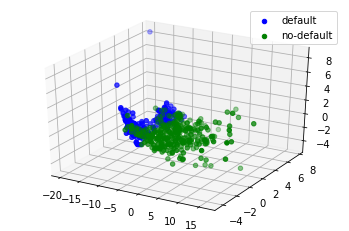

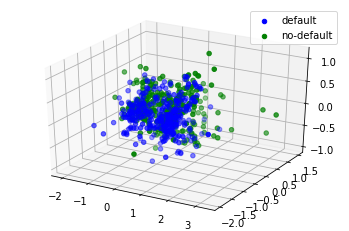

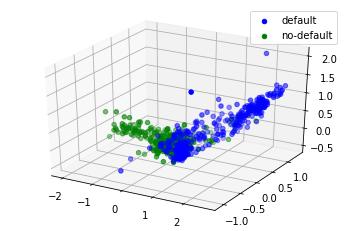

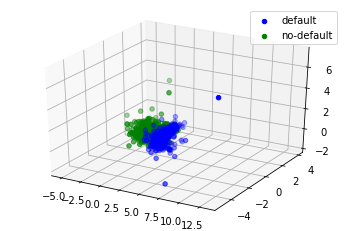

In [135]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt


def plt_view_3D(v_list, ys, name):
    v_hidden = np.concatenate(v_list, 0)
    pca = PCA(n_components=3)
    v_low = pca.fit_transform(v_hidden)
    
    v_positive = v_low[ys==1.]
    v_negative = v_low[ys==0.]
    sample_idx = random.sample(list(range(v_negative.shape[0])), v_positive.shape[0])
    v_negative = v_negative[sample_idx]
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(v_positive[:, 0], v_positive[:, 1], v_positive[:, 2], c = 'b', label='default')
    ax.scatter(v_negative[:, 0], v_negative[:, 1], v_negative[:, 2], c = 'g', label='no-default')
#     ax.view_init(0, 100)
    plt.legend()
    plt.savefig('pdf/%s_3d.pdf' % name, bbox_inches='tight')
    plt.show()

plt_view_3D(v_final_list, ys, 'v_final')
plt_view_3D(v_g_user_attribute_list, ys, 'v_user_attribute')
plt_view_3D(v_g_app_list, ys, 'v_app')
plt_view_3D(v_g_app_inlog_list, ys, 'v_app_inlog')

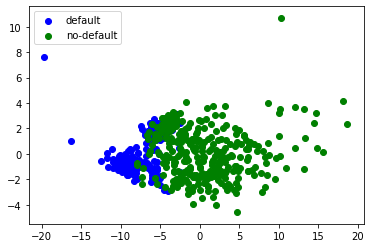

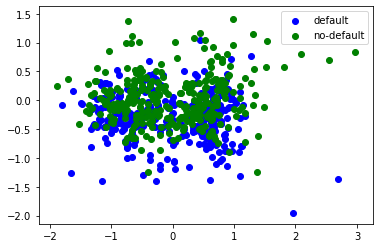

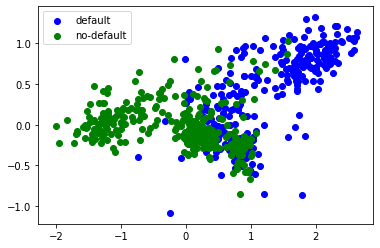

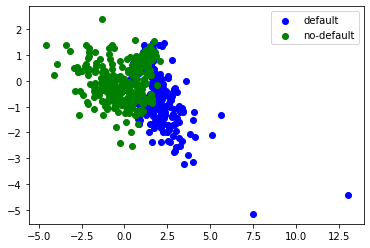

In [136]:
def plt_view_2D(v_list, ys, name):
    v_hidden = np.concatenate(v_list, 0)
    pca = PCA(n_components=3)
    v_low = pca.fit_transform(v_hidden)
    
    v_positive = v_low[ys==1.]
    v_negative = v_low[ys==0.]
    sample_idx = random.sample(list(range(v_negative.shape[0])), v_positive.shape[0])
    v_negative = v_negative[sample_idx]
    fig = plt.figure()
    plt.scatter(v_positive[:, 0], v_positive[:, 1], c = 'b', label='default')
    plt.scatter(v_negative[:, 0], v_negative[:, 1], c = 'g', label='no-default')
#     ax.view_init(0, 100)
    plt.legend()
    plt.savefig('pdf/%s_2d.pdf' % name, bbox_inches='tight')
    plt.show()


plt_view_2D(v_final_list, ys, 'v_final')
plt_view_2D(v_g_user_attribute_list, ys, 'v_user_attribute')
plt_view_2D(v_g_app_list, ys, 'v_app')
plt_view_2D(v_g_app_inlog_list, ys, 'v_app_inlog')

## v2

In [19]:
def get_views(model, master_ids):

    torch_dataset = AppDataset(master_ids)
    data_loader = Data.DataLoader(
        dataset=torch_dataset,      
        batch_size=args.batch_size,      
        shuffle=False,
        collate_fn=collate_fn,
        num_workers = args.n_worker,
    )
    
    hidden_dict_list = []
    with torch.no_grad():
        for step, data in enumerate(data_loader):
            loss, y1, y2, y3, y4, hidden_dict = model(data)
            hidden_dict_list.append(hidden_dict)
        

    return hidden_dict_list

### compare full sample and missing-sample v_final

In [21]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

def get_full_missing_view_3D(used_ids, ys, v_list, use_PCA=True):
    v_hidden = np.concatenate(v_list, 0)
    if use_PCA:
        pca = PCA(n_components=3)
        v_low = pca.fit_transform(v_hidden)
    else:
        embedding = MDS(n_components=3)
        v_low = embedding.fit_transform(v_hidden)
    
    full_sample_idxs, missing_sample_idxs = [], []
    for i, used_id in enumerate(used_ids):
        if used_id in user_info_set and used_id in install_behave_set and \
        used_id in install_list_set and used_id in user_log_set:
            full_sample_idxs.append(i)
        else:
            missing_sample_idxs.append(i)
    
    v_low_full_sample = v_low[full_sample_idxs]
    full_sample_y = ys[full_sample_idxs]
    v_low_full_sample_positive = v_low_full_sample[full_sample_y==1.]
    v_low_full_sample_negative = v_low_full_sample[full_sample_y==0.]
    
    sample_idx = random.sample(list(range(v_low_full_sample_negative.shape[0])), v_low_full_sample_positive.shape[0])
    v_low_full_sample_negative = v_low_full_sample_negative[sample_idx]

    v_low_missing_sample = v_low[missing_sample_idxs]
    missing_sample_y = ys[missing_sample_idxs]
    v_low_missing_sample_positive = v_low_missing_sample[missing_sample_y==1.]
    v_low_missing_sample_negative = v_low_missing_sample[missing_sample_y==0.]

    sample_idx = random.sample(list(range(v_low_missing_sample_negative.shape[0])), v_low_missing_sample_positive.shape[0])
    v_low_missing_sample_negative = v_low_missing_sample_negative[sample_idx]
    
    return v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive,\
                            v_low_missing_sample_negative

def plt_full_missing_view_3D(v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive,
                            v_low_missing_sample_negative, name, view):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(v_low_full_sample_positive[:, 0], v_low_full_sample_positive[:, 1], v_low_full_sample_positive[:, 2],
               c = '#FFA07A', label='full sample  v_final (default)')
    ax.scatter(v_low_full_sample_negative[:, 0], v_low_full_sample_negative[:, 1], v_low_full_sample_negative[:, 2], 
               c = '#000080', label='full sample  v_final (no-default)')
    ax = fig.gca(projection='3d')
    ax.scatter(v_low_missing_sample_positive[:, 0], v_low_missing_sample_positive[:, 1],
               v_low_missing_sample_positive[:, 2], c = '#006400', label='missing sample  v_final (default)')
    ax.scatter(v_low_missing_sample_negative[:, 0], v_low_missing_sample_negative[:, 1],
               v_low_missing_sample_negative[:, 2], c = '#FFFF00', label='missing sample  v_final (no-default)')

    ax.view_init(view[0], view[1])

    plt.legend(loc='upper left')
    plt.savefig('pdf/%s_3d.pdf' % name, bbox_inches='tight')
    plt.show()
    

In [22]:
used_ids = all_train_id[:10000]
hidden_dict_list = get_views(multiview_net, used_ids)
v_final_list, v_origin_list = [], []

for hidden_dict in hidden_dict_list:
    v_final_list.append(hidden_dict['v_final'].cpu().detach().numpy())
    v_origin_list.append(hidden_dict['v_origin'].cpu().detach().numpy())
    
ys = df_master_records['target_1m30+'].loc[used_ids].values
logging.info('start')
v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive, v_low_missing_sample_negative = \
get_full_missing_view_3D(used_ids, ys, v_final_list, True)
logging.info('end')


2021-03-03 17:48:13,725 - INFO - start
2021-03-03 17:48:14,081 - INFO - end


<IPython.core.display.Javascript object>


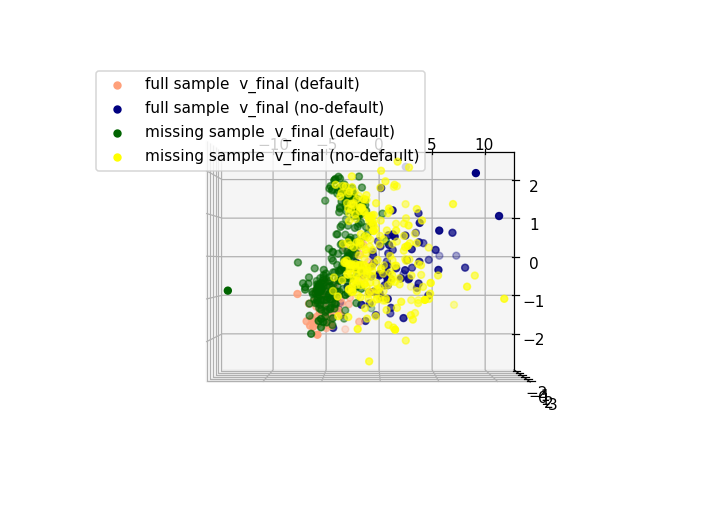

In [23]:
plt_full_missing_view_3D(v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive, 
                         v_low_missing_sample_negative, 'trainset_full_missing_sample', (90, -90))

#### test set

In [23]:
used_ids = all_test_id[:10000]
hidden_dict_list = get_views(multiview_net, used_ids)
v_final_list, v_origin_list = [], []

for hidden_dict in hidden_dict_list:
    v_final_list.append(hidden_dict['v_final'].cpu().detach().numpy())
    v_origin_list.append(hidden_dict['v_origin'].cpu().detach().numpy())
    
ys = df_master_records['target_1m30+'].loc[used_ids].values
v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive, v_low_missing_sample_negative = \
get_full_missing_view_3D(used_ids, ys, v_final_list, True)

<IPython.core.display.Javascript object>


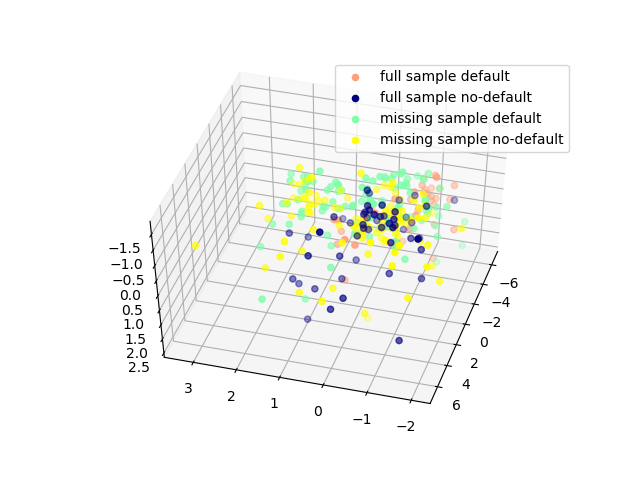

In [24]:
plt_full_missing_view_3D(v_low_full_sample_positive, v_low_full_sample_negative, v_low_missing_sample_positive, 
                         v_low_missing_sample_negative, 'testset_full_missing_sample', (40, 105))

### missing sample v_origin v_final

In [29]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

def get_missing_sample_vfinal_vorigin(missing_sample_idxs, ys, v_final_list, v_origin_list, use_PCA=True):
    v_final = np.concatenate(v_final_list, 0)[missing_sample_idxs]
    v_origin = np.concatenate(v_origin_list, 0)[missing_sample_idxs]
    ys = ys[missing_sample_idxs]
    v_all = np.concatenate([v_final, v_origin], 0)
    
    if use_PCA:
        pca = PCA(n_components=3)
        v_low = pca.fit_transform(v_all)
    else:
        embedding = MDS(n_components=3)
        v_low = embedding.fit_transform(v_all)

    v_low = pca.fit_transform(v_all)
    v_final_low = v_low[:v_final.shape[0]]
    v_origin_low = v_low[v_final.shape[0]:]

    
    v_final_low_positive = v_final_low[ys==1.]
    v_final_low_negative = v_final_low[ys==0.]
    
    sample_idx = random.sample(list(range(v_final_low_negative.shape[0])), v_final_low_positive.shape[0])
    v_final_low_negative = v_final_low_negative[sample_idx]

    
    v_origin_low_positive = v_origin_low[ys==1.]
    v_origin_low_negative = v_origin_low[ys==0.]

    sample_idx = random.sample(list(range(v_origin_low_negative.shape[0])), v_origin_low_positive.shape[0])
    v_origin_low_negative = v_origin_low_negative[sample_idx]
    return v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative
    
def plt_view_3D_missing_sample_vfinal_vorigin(v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative,
                                             name, view):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.scatter(v_final_low_positive[:, 0], v_final_low_positive[:, 1], v_final_low_positive[:, 2],
               c = '#FFA07A', label='missing sample v_final (default)')
    ax.scatter(v_final_low_negative[:, 0], v_final_low_negative[:, 1], v_final_low_negative[:, 2], 
               c = '#000080', label='missing sample v_final (no-default)')
    
    ax = fig.gca(projection='3d')
    ax.scatter(v_origin_low_positive[:, 0], v_origin_low_positive[:, 1],
               v_origin_low_positive[:, 2], c = '#006400', label='missing sample v_origin (default)')
    ax.scatter(v_origin_low_negative[:, 0], v_origin_low_negative[:, 1],
               v_origin_low_negative[:, 2], c = '#FFFF00', label='missing sample v_origin (no-default)')

#     ax.view_init(45, 90)
    ax.view_init(view[0], view[1])

    plt.legend(loc='upper left')
    plt.savefig('pdf/%s_3d.pdf' % name, bbox_inches='tight')
    plt.show()

    

In [27]:
used_ids = all_train_id[:10000]
hidden_dict_list = get_views(multiview_net, used_ids)
v_final_list, v_origin_list = [], []

for hidden_dict in hidden_dict_list:
    v_final_list.append(hidden_dict['v_final'].cpu().detach().numpy())
    v_origin_list.append(hidden_dict['v_origin'].cpu().detach().numpy())

full_sample_idxs, missing_sample_idxs = [], []
for i, used_id in enumerate(used_ids):
    if used_id in user_info_set and used_id in install_behave_set and \
    used_id in install_list_set and used_id in user_log_set:
        full_sample_idxs.append(i)
    else:
        missing_sample_idxs.append(i)
        
ys = df_master_records['target_1m30+'].loc[used_ids].values
v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative = \
get_missing_sample_vfinal_vorigin(missing_sample_idxs, ys, v_final_list, v_origin_list, True)

<IPython.core.display.Javascript object>


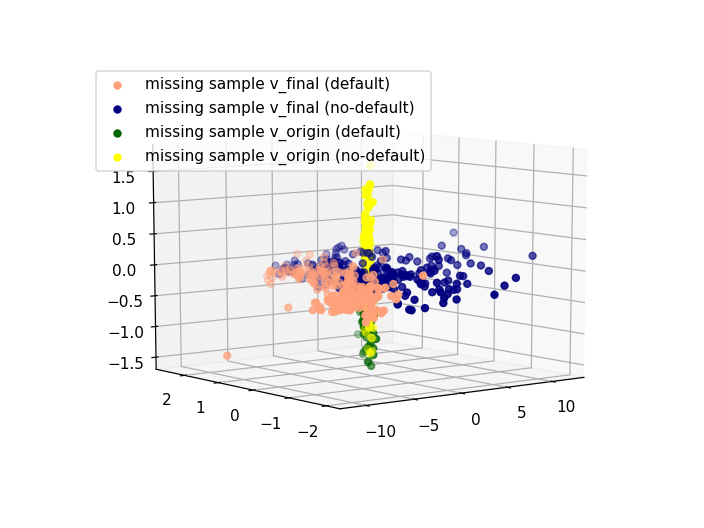

In [30]:
plt_view_3D_missing_sample_vfinal_vorigin(v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative,
                                          'train_missing_sample_before_after', (9, -128))

#### test set

In [28]:
used_ids = all_test_id[:10000]
hidden_dict_list = get_views(multiview_net, used_ids)
v_final_list, v_origin_list = [], []

for hidden_dict in hidden_dict_list:
    v_final_list.append(hidden_dict['v_final'].cpu().detach().numpy())
    v_origin_list.append(hidden_dict['v_origin'].cpu().detach().numpy())

full_sample_idxs, missing_sample_idxs = [], []
for i, used_id in enumerate(used_ids):
    if used_id in user_info_set and used_id in install_behave_set and \
    used_id in install_list_set and used_id in user_log_set:
        full_sample_idxs.append(i)
    else:
        missing_sample_idxs.append(i)
        
ys = df_master_records['target_1m30+'].loc[used_ids].values
v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative = \
get_missing_sample_vfinal_vorigin(missing_sample_idxs, ys, v_final_list, v_origin_list, True)

<IPython.core.display.Javascript object>


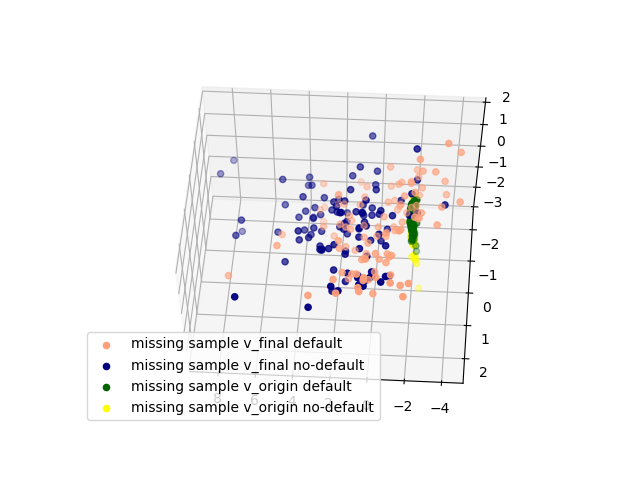

In [29]:
plt_view_3D_missing_sample_vfinal_vorigin(v_final_low_positive, v_final_low_negative, v_origin_low_positive, v_origin_low_negative,
                                          'test_missing_sample_before_after', (45, 65))